# ProjectPegasus

Exam project for the Artificial Intelligence Fundamentals course, a.y. 2023/2024

Notebook and code by the NetRiders team: Giordano Scerra, Andrea Marino, Yuri Ermes Negri, Davide Borghini, Davide Marchi

---

## Introduction

This project focuses on the task of riding a pony. To do so, the agent:
- Picks up some carrots
- Feeds the pony with carrots, to pacify him and increase his tameness
- Looks for a saddle
- Applies the saddle on the pony and rides it

The one listed are not only steps that are necessary to perform the task successfully, but also *subtasks* on their own. As it will be thoroughly described later, the task is solved by selecting the most appropriate subtask and execute it. The execution of the subtask is controlled by a knowledge base.

## Methodologies

Our code is structured in three main files:
- **Map.py**: These class' methods are used for the interactions with the environment: extracting information from the cells, rendering the level and making a proper step in the game (i.e. applying the actions).
- **Agent.py**: Interacts with Map.py and the knowledge base with two methods: `percept()` and `act()`. 
    - `percept()`: reads information from the environment - using attributes from Map - and populates the knowledge base, using methods from the KBwrapper.
    - `act()`: Queries the knowledge base for the best subtask to execute and launch the related methods.
- **KBwrapper.py**: For the agent, its knowledge base is an instance of this class. Based on pyswip library, its methods are used to manage the "kb.pl" Prolog knowledge base by asserting, retracting and querying the appropriate predicates. 

Our project is related with the course for these key topics:
- A* search algorithm
- Knowledge Base

### Subtasks and Interrupts

We decided to implement an intelligent system for decision making based on interruptions. As already mentioned, the `agent.act()` queries the knowledge base for the best subtask to perform among these ones:
- *getCarrot* : to go and collect the nearest carrot
- *getSaddle* : to go and collect the saddle, which is necessary to ride the pony 
- *feedSteed* : to feed the the pony by throwing carrots at it
- *applySaddle* : to apply the saddle to the pony
- *rideSteed* : to attempt to ride the pony
- *explore* : to explore unseen zones of the map
- *attackEnemy* : go towards an enemy and make a single attack at it
- *eat* : take an item from the inventory and eat it to sate the agent's hunger or cure it from blindness

Of course, each subtask requires to undertake a sequence of actions. After an action is performed, the knowledge base is queried again for an interruption signal, whose purpose is to notify the agent that the premises to continue that specific subtask are no longer valid and a subtask switch is needed. In particular, after every step the agent makes in the environment (basically after every `env.step`), the premises for the interruption of the current subtask are checked, and if satisfied the flow of actions required to perform the subtask is interrupted. After that, the knowledge base is queried again for the best subtask to perform next. 

We drew inspiration for the basic functioning of the agent in our project from the *knowledge_base_agent* paradygm that we saw during the course. In fact, whenever the agent has to do an action, it firsts senses the environment by calling the `percept()` method, which acts as a TELL, then performs an action, and finally queries the knowledge base for an interruption. Hence the ASK part is done in a two-fold way by both the interruption query and by the subtask query. 

We thought that this approach is both necessary for the task at hand, as the environment changes repeatedly and unpredictably due to things such as the activity of the pony and monsters, and interesting to see in action.


### Knowledge Base

As discussed during the oral presentation, and as described in the previous paragraph, the knowledge base is where both the information is stored and the decision making process for the agent takes place. This entity itself is divided in two parts, which can be distinguished by the two different languages in which they're written: Prolog and Python. In fact, Python is used as a wrapper interface to control the Prolog part, thanks to the open source library pyswip. 
The subtasks in the knowledge base are defined in order of relevance. We have:
- getCarrot
- feedSteed
- getSaddle
- applySaddle
- explore (this subtask is chosen when no premise is satisfied for another subtask to start)
- eat
- attackMonster

After the subtask's section, in our code we have the interruption's section. Here we can find, for every subtask, its own interruption clause.

Then we have some facts, like the pony's tameness assigned to 20, or the definition of a steed.

Eventually, there is a section where we store some observations like the number of carrots or saddles in our possession, or the pony's current tameness. 

In the (rare) case where the agent has no better action than 'explore' and it performs 3 full map patrols, the subtask switches to riding. This was implemented to avoid endless exploring, it's a desperate last resort option.

## Live demo

Let's see a small demo of our project. In order to run the following code, and in general to replicate our work, make sure that:
1. this notebook stays inside the folder in which it was delivered. This is necessary to resolve the imports
2. the following packages that were used in the hands-on sessions are installed: `pyswip`, `minihack`, `numpy`, `nle`, `matplotlib`, `notebook` 

Let's first import the classes that were described in the previous sections, and that are used in all the tests

In [1]:
from utils.map import Map
from utils.agent import Agent

We implemented three distances, to test them as heuristics for the A* algoritm. We ran all of our tests using `manhattan_distance`, but other heuristics can be tried out by passing them as parameters to `agent.act()`

Of course, the correctness of the algorithm is independent from the used heuristic, as long as it is a correct one.

In [2]:
from utils.heuristics import manhattan_distance, infinity_distance, euclidean_distance
heuristic = manhattan_distance

We provided plenty of examples to explore, and a lot of parameters to set at will. Let's create a simple map in which there are three enemies (a lichen, a jackal and a newt), an untamed pony and a saddle.

Let's also create the agent, and first sense the environment.

In [3]:
level = Map(level=2, pony=True, enemies=True)

steinbeck = Agent()
steinbeck.percept(game_map=level)

Let's display the map...

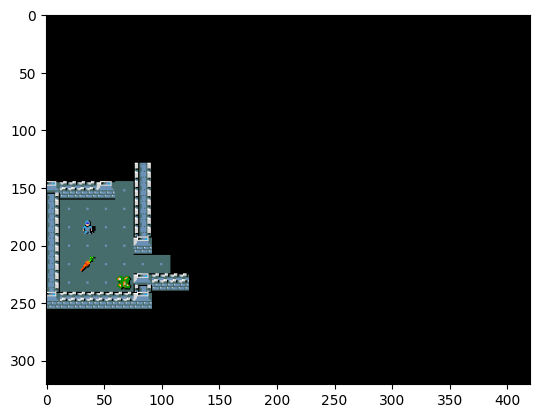

In [4]:
# the graphic=True can be used only if level in [0,1,2,3] in the Map class
level.render(graphic=True)

... and run the example. This is as simple as asking the agent to act in the environment.

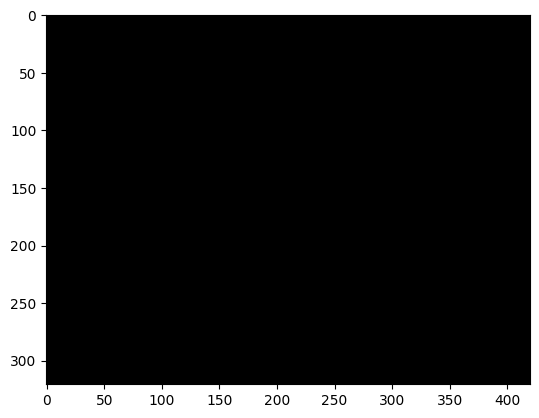

In [5]:
while(not level.is_episode_over()):
    steinbeck.act(level, show_steps=True, graphic=True, delay=0.0)


Let's see how well our valiant Steinbeck performed in this level

In [6]:
print(sum(level.rewards))

1009.0


Here, we sum all the rewards coming from the events we created.

First of all, why a sum? 
Since we decided to append the reward assigned in each state of the environment to a list, we end up with a pretty long one, especially in gargantuan mazes.
The events we defined and chose to record are getCarrots and MountEvent which respectively assign a reward of one point for picking up a carrot and 1000 points for mounting the steed.

We discussed extensively about using an event that'd give off a reward of -1 for each step taken by the agent and came to the conclusion that it would be inadequate for our task: we wished to face multiple contingencies while taming the steed: fighting a monster in our path to a carrot or near the steed, finding all the carrots, getting the steed to drop the saddle if it ever wished to take it and many more. Because of this, using such a reward would have pushed us to solve the task *faster* instead of *better*, becoming a sort of toxic inductive bias on our work: we'd have been more focused on finding good heuristics to finish the level in time instead of solving the many problems we had to face. 
Also, since the maps can be different both in size and complexity, adding such a metric would meddle the evaluations of the performance of our agent: on bigger, more difficult maps to cross and explore, the agent would forcibly be penalized even if it managed to find all the carrots (which maximize its probability to apply the saddle to the pony and mount it), kill any monster that put it or its steed in danger or even cure itself from blindness or the hunger states.

## Assessment

## Conclusions

---

## Appendix